In [1]:
# load package# load p 
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import cross_validation


# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/esunfrauddetectiongame1809/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')
#你可以选择修改 ast_note_iteractively kernel 选项来使得 Jupyter 为每一行的变量或语句执行这个操作，以便你可以立即看到多条语句一起输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
S1=pd.read_csv('S1.csv',encoding='big5')#此為抽樣結果
train_diss=pd.read_csv('train_diss.csv',encoding='big5')#只把DATETIME改成秒數的training data

In [3]:
S1.info() #4597筆盜刷案件 in training data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597 entries, 0 to 4596
Data columns (total 59 columns):
TXKEY                            4597 non-null object
CHID                             4597 non-null object
CANO                             4597 non-null int64
MCHNO                            4595 non-null object
ACQIC                            4594 non-null float64
MCC                              4597 non-null object
CONTP                            4597 non-null object
ETYMD                            4537 non-null float64
ECFG                             4597 non-null int64
INSFG                            4597 non-null int64
ITERM                            4597 non-null int64
BNSFG                            4597 non-null int64
BNSPT                            4597 non-null int64
FLAM1                            4597 non-null float64
STOCN                            4592 non-null object
SCITY                            4354 non-null object
OVRLT                           

In [4]:
# 挑出正常案件
train0=train_diss[train_diss.FRAUD_IND==0]
train=train0.append(S1, ignore_index=True)

In [5]:
test=pd.read_csv('test_diss.csv',encoding='big5')
submit=pd.read_csv('sampleSubmission.csv',encoding='big5')
data=train.append(test, ignore_index=True)

In [6]:
data['s_in_a_Day']= data['DATETIME']%(60*60*24)
import math
data['h_in_a_Day']= data['s_in_a_Day'].map(lambda x: math.floor(x/(60*60)))

In [7]:
import seaborn as sns
g=sns.FacetGrid(data, col='FRAUD_IND',xlim=[0,24])
g.map(sns.distplot,'h_in_a_Day', kde=True)

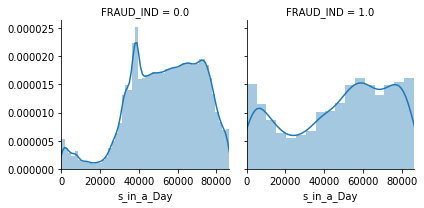

In [8]:
import seaborn as sns
g=sns.FacetGrid(data, col='FRAUD_IND',xlim=[0,86400])
g.map(sns.distplot,'s_in_a_Day', kde=True)

In [9]:
# 轉格式為category
data= data.astype({'AGNO':'category', 'CATP1':'category', 'CC_CUST_LEVEL':'category', 'CONTP':'category', 'CUORG':'category', 'MCC':'category',
       'MCHNO':'category', 'PAY_TYPE':'category', 'SCITY':'category', 'STOCN':'category', 'TSCFG':'category', 'h_in_a_Day':'category'})

In [10]:
# 區分train test
dataTrain = data[pd.notnull(data['FRAUD_IND'])]
dataTest = data[~pd.notnull(data['FRAUD_IND'])]
dataTrain.columns
del(data)

Index(['ACCT_VINTAGE', 'ACQIC', 'AGE', 'AGNO', 'ANDFG', 'APPFG',
       'AVAILABLE_LIMIT_AMT', 'BNSFG', 'BNSPT', 'BONUS_POINTS', 'CANO',
       'CATP1', 'CATP2', 'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE', 'CC_VINTAGE',
       'CGDCT', 'CHID', 'CONTP', 'CREDIT_LIMIT_AMT', 'CREDIT_REVOLVING_RATE',
       'CREDIT_USE_RATE', 'CUORG', 'CURRENT_CASH_ADV_AMT', 'CURRENT_FEE',
       'CURRENT_INSTALLMENT_BAL', 'CURRENT_INSTALLMENT_PURCH_AMT',
       'CURRENT_PURCH_AMT', 'CURRENT_VIO_AMT', 'DATETIME', 'ECFG', 'EDU_CODE',
       'ETYMD', 'FALLBACK_IND', 'FEDFG', 'FEEFG', 'FLAM1', 'FRAUD_IND',
       'GENDER_CODE', 'INCOME_RANGE_CODE', 'INSFG', 'ITERM', 'LSCFG',
       'LST_CYCLE_UNPAID_BAL', 'MARITAL_STATUS_CODE', 'MCC', 'MCHNO',
       'NATION_CODE', 'OCUP_CODE', 'OVRLT', 'PAY_TYPE', 'POSITION_CODE',
       'REVOLVING_AMT', 'REVOLVING_INTEREST', 'SAMFG', 'SCITY', 'STOCN',
       'TSCFG', 'TXKEY', 's_in_a_Day', 'h_in_a_Day'],
      dtype='object')

### 只拿要的feature

In [11]:
dataTrain = dataTrain[['TXKEY', 'ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT',  #'CANO',
       'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE','CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1', 'FRAUD_IND',
       'GENDER_CODE', 'INSFG', 'ITERM',#'LSCFG',
        'MCC', 'MCHNO',
        'OVRLT', 'PAY_TYPE',# 'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
        'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day']]
#去掉y
dataTest = dataTest[['ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT', # 'CANO',
       'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE','CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1',
       'GENDER_CODE',  'INSFG', 'ITERM', #'LSCFG',
        'MCC', 'MCHNO',
       'OVRLT', 'PAY_TYPE', #'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
       'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day']]
#去掉key
X_feature = dataTrain[['ACQIC', 'AGE', 'ANDFG', 'APPFG','AVAILABLE_LIMIT_AMT',
        'BNSFG', 'BNSPT', # 'CANO',
        'CC_CUST_LEVEL', 'CC_PAY_LEVEL_CODE',
       'CC_VINTAGE', 'CGDCT', 'CONTP', 'CREDIT_LIMIT_AMT',
        'CREDIT_USE_RATE','CURRENT_PURCH_AMT', 'ECFG', 'EDU_CODE', 'ETYMD',
       'FALLBACK_IND', 'FEEFG','FEDFG', 'FLAM1',
       'GENDER_CODE',  'INSFG', 'ITERM',# 'LSCFG',
        'MCC', 'MCHNO',
       'OVRLT', 'PAY_TYPE', #'POSITION_CODE','REVOLVING_AMT', 'REVOLVING_INTEREST',
       'SAMFG', 'SCITY', 'STOCN','TSCFG', 's_in_a_Day', 'h_in_a_Day']]
y_t =dataTrain['FRAUD_IND']

In [12]:
#把上面dataTrain.columns的結果貼到dataTrain，再去掉'Survived'
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=13)

In [13]:
# Function for Measure Performance
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [14]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators = 150, random_state=0) #, objective = 'binary'


param_grid = {
    'objective':['binary'],
    'learning_rate': [0.11], 
    'num_leaves': [64],
    'feature_fraction': [0.8],
    'bagging_fraction': [0.95],
    'max_depth':[10],
    #'max_bin': [6],
    'bagging_freq':[3],
    'lambda_l1': [20] , #[44,133] then 44 [44,88] then 44 np.arange(38,44,1) np.arange(16,20,1)
    'lambda_l2': [7] ,#np.arange(11,15,1) then 13
    #'min_split_gain': [0.04], 
    'min_child_weight': [2] 
}

LGBM_grid = GridSearchCV(estimator, param_grid,scoring='f1')
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators = 150, random_state=0, 
                                     objective = LGBM_grid.best_params_['objective'],
                                     learning_rate = LGBM_grid.best_params_['learning_rate'],
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                             bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              #max_bin = LGBM_grid.best_params_['max_bin'],
                                bagging_freq = LGBM_grid.best_params_['bagging_freq'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            #min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight']
                                    )
LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print("Predicting is over")

Start training...


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=150,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'objective': ['binary'], 'learning_rate': [0.11], 'num_leaves': [64], 'feature_fraction': [0.8], 'bagging_fraction': [0.95], 'max_depth': [10], 'bagging_freq': [3], 'lambda_l1': [20], 'lambda_l2': [7], 'min_child_weight': [2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Best parameters found by grid search are: {'bagging_fraction': 0.95, 'bagging_freq': 3, 'feature_fraction': 0.8, 'lambda_l1': 20, 'lambda_l2': 7, 'learning_rate': 0.11, 'max_depth': 10, 'min_child_weight': 2, 'num_leaves': 64, 'objective': 'binary'}
Start predicting...
Predicting is over


Accuracy:0.993
Classification report
             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00    136886
        1.0       0.79      0.42      0.55      1438

avg / total       0.99      0.99      0.99    138324

Confusion matrix
[[136729    157]
 [   839    599]]
ROC AUC Score
0.9818895318657188
Feature importances: [103, 554, 9, 121, 442, 0, 0, 93, 75, 693, 22, 0, 311, 342, 484, 31, 55, 60, 2, 0, 1, 471, 30, 4, 1, 626, 681, 0, 0, 3, 541, 250, 8, 247, 666]
Plot feature importances...


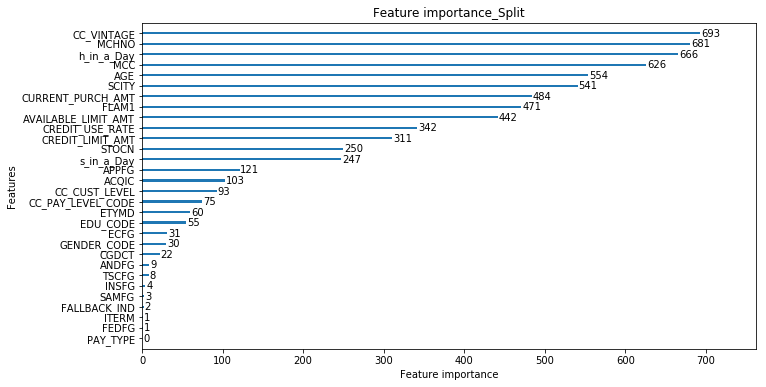

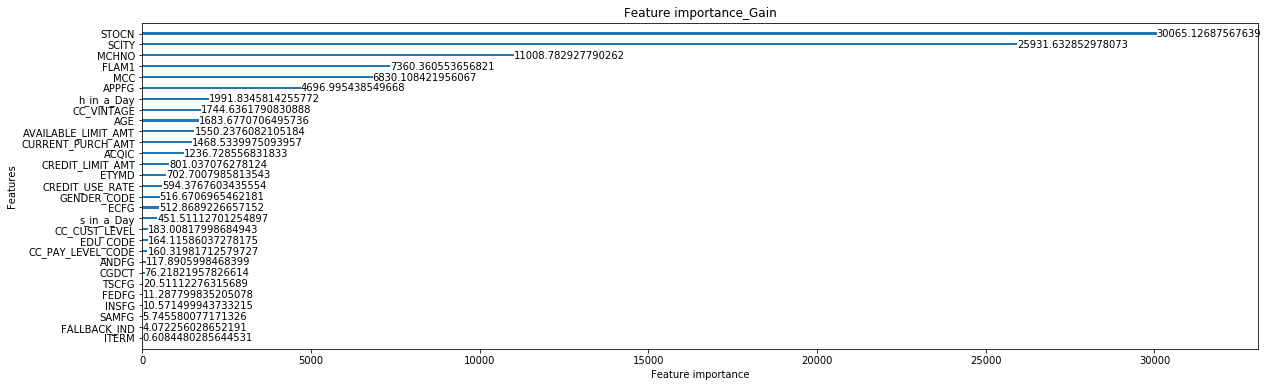

In [15]:
#對test算performance
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
split_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, ignore_zero=False,figsize=(11, 6),grid=False, title='Feature importance_Split')
gain_importance = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=30, importance_type='gain',figsize=(20, 6),grid=False, title='Feature importance_Gain')


In [16]:
#對test算 f1_score
from sklearn.metrics import f1_score
y_pred_val = LGBM_grid_final_fit.predict(X_test)
f1_score(y_test,y_pred_val,average=None)

array([0.99637098, 0.54603464])

In [17]:
#拿全部的dataTrain來建
LGBM_grid_final_fit_all = LGBM_grid_final.fit(X_feature, y_t)

In [18]:
#predict Test data
#submit the data to kaggle
LGBM_grid_final_fit_res =LGBM_grid_final_fit_all.predict(dataTest)
submit['FRAUD_IND'] = LGBM_grid_final_fit_res
#submit['Survived'] = GBDT_res
submit['FRAUD_IND'] = submit['FRAUD_IND'].astype(int)
ttl= submit['FRAUD_IND'].sum()
print('偽冒筆數：',ttl)

偽冒筆數： 1338


In [19]:
submit.to_csv("light_submit.csv", index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/esunfrauddetectiongame1809'

In [20]:
print('This submission: public score: 0.37621 and private score: 0.32414 ')

This submission: public score: 0.37621 and private score: 0.32414 
